In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


#setting to make numbers readable 
pd.options.display.float_format = '{:20.2f}'.format

#to diplay all columns in the output
pd.set_option('display.max_columns',999)

In [2]:
#imorting the dataset from uci
df = pd.read_excel('Documents/R/online_retail_II.xlsx',sheet_name= 0)

## Data exploration

In [4]:
#checking the first few rows of the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [5]:
#checking the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Notable I have over 500 000 rows of data and most of the columns have fewer null values only customerID is missing a lot of values something worth exploring, datetime is already in the correct format.

In [7]:
#checking the stattistics of  the numeric data
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


The minimum value for quantity is unexpectedly nagative together with price, which is worth exploring.

In [9]:
#checking the statistics of the catergorical data
df.describe(include= "O")

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [10]:
#Exploring the null values in the customerId
df[df['Customer ID'].isnull()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


Notable some of the customerID with missing values have a price of zero which doesnt make sense, though some of the transactions look legit but the strategy i am going to use is to drop all the rows with null Customer Id since its near impossibe to infer which customer are we refering to.

In [12]:
#checking the nagative quantity 
df[df['Quantity']<0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


Evidently the transaction with negative quantity are legit but taking a closer look at its invoices its start with a C meaning it was a cancelled transaction ,that is why it appears as negative.

In [14]:
#Checking the varous types of invoces I have
df['Invoice']=df['Invoice'].astype(str)
df[df['Invoice'].str.match('^\\d{6}$')==False]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


Validation is needed to confirm that "C" is the only digit that appears in from of the Invoices

In [16]:
#replacing all the  digits with  an emapty string
df['Invoice'].str.replace('[0-9]', "",regex = True).unique()

array(['', 'C', 'A'], dtype=object)

Using the regular expressions its notable that "C" is not the only letter in the Invoices Also "A" 

In [18]:
df[df['Invoice'].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


This transaction looks like accounting adjusted bad debt with also dont have a CustomerId and we dont have enough information about it we will just drop them.

In [20]:
#Inspecting the stock code as stated that its a five digit number
df['StockCode'] = df['StockCode'].astype("str")
df[df['StockCode'].str.match('^\\d{5}$')==False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


Notable Stockcode is not 5 digit number in all the rows as stated in the project description some include letters , Not much infomation is provided about this values which I will assume these are valid transcation and further exploration about the different stock codes is taken

In [22]:
#checking the unique digits we have in the stock codes
df[(df['StockCode'].str.match('^\\d{5}$')==False) &(df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$')==False)]['StockCode'].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

It looks like we have a lot of the stockcodes that dont follow the expected patterns, This needs to be investigated one by one

## Data Cleaning

In [25]:
cleaned_df = df.copy()

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [26]:
#Cleaning the invoice column
cleaned_df['Invoice'] = cleaned_df['Invoice'].astype(str)

#creating a musk, basically a filter
musk = (cleaned_df['Invoice'].str.match('^\\d{6}$')==True)

cleaned_df = cleaned_df[musk]
cleaned_df


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [27]:
#Cleaning the stockcodes
cleaned_df['StockCode'] = cleaned_df['StockCode'].astype(str)

#creating a filter
musk = (df['StockCode'].str.match('^\\d{5}$')==True 
        |(df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$')==True |
         (df['StockCode'].str.match('^PADS$')==True)))

cleaned_df = cleaned_df[musk]

cleaned_df 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [28]:
#Checking the data infomation again
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,437330.00,437330,437330.00,350929.00
mean,11.21,2010-07-03 10:01:32.490796544,3.37,15360.28
min,-9600.00,2009-12-01 07:45:00,0.00,12346.00
25%,1.00,2010-03-28 11:02:00,1.25,13985.00
50%,4.00,2010-07-15 11:08:00,2.10,15311.00
75%,12.00,2010-10-18 14:07:00,4.21,16797.00
max,19152.00,2010-12-09 20:01:00,1157.15,18287.00
std,109.00,NaN,5.23,1678.21


 Evidently we still have nagative quantity and price of zero which doesnt make sense, so further exploration is done.

In [30]:
#Dropping the nulls in the customerId
cleaned_df.dropna(subset= ['Customer ID'], inplace = True)

In [31]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,350929.00,350929,350929.00,350929.00
mean,13.70,2010-07-05 17:14:04.387041024,2.98,15360.28
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-31 17:29:00,1.25,13985.00
50%,5.00,2010-07-18 13:42:00,1.95,15311.00
75%,12.00,2010-10-17 14:26:00,3.75,16797.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,100.08,NaN,4.42,1678.21


We managed to get rid of the nagative quantity , now we left with zero price, which need to be analyzed further if it means anything

In [33]:
len(cleaned_df[cleaned_df['Price'] == 0])

27

Only 27 records , which is not pretty much, we can just remove them 

In [35]:
cleaned_df = cleaned_df[cleaned_df['Price'] > 0]

In [36]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,350902.00,350902,350902.00,350902.00
mean,13.70,2010-07-05 17:18:45.468763136,2.98,15360.38
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-31 17:29:00,1.25,13985.00
50%,5.00,2010-07-18 13:42:00,1.95,15311.00
75%,12.00,2010-10-17 14:26:00,3.75,16797.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,100.08,NaN,4.42,1678.17


## How much data we lost after cleaning?

In [38]:
len(cleaned_df)/len(df)

0.667798371334885

Dropped about roughly 33% of records

# Feature Engineering

In this section we will be creating ne data based of the data we already have . Since we are followin the RFM method (Recency, Frequency and Monetart value) to perfom clustering , we will be using left will only these variables at the end

In [42]:
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [43]:
#Creating the Linesales total
cleaned_df['LineSalesTotal'] = cleaned_df['Quantity']*cleaned_df['Price']

In [44]:
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,LineSalesTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom,39.60
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00


In [45]:
aggregated_df = cleaned_df.pivot_table(index = ['Customer ID'], values=['Invoice','LineSalesTotal','InvoiceDate'],
                                       aggfunc= {'Invoice': 'nunique','LineSalesTotal':'sum','InvoiceDate': 'max'})
aggregated_df.columns = ['Frequency','LastInvoiceDate','MonetaryValue']
aggregated_df.reset_index(inplace=True)



In [46]:
#Creating the recency column in days
Last_day = aggregated_df['LastInvoiceDate'].max()

In [47]:
#How long did the person make bought relative to the last date
aggregated_df['Recency'] = (Last_day-aggregated_df.LastInvoiceDate).dt.days

In [48]:
aggregated_df

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency
0,12346.00,2,2010-06-28 13:53:00,144.02,164
1,12347.00,2,2010-12-07 14:57:00,966.87,2
2,12348.00,1,2010-09-27 14:59:00,221.16,73
3,12349.00,2,2010-10-28 08:23:00,1946.64,42
4,12351.00,1,2010-11-29 15:23:00,300.93,10
...,...,...,...,...,...
4243,18283.00,6,2010-11-22 15:30:00,563.19,17
4244,18284.00,1,2010-10-04 11:33:00,391.28,66
4245,18285.00,1,2010-02-17 10:24:00,361.10,295
4246,18286.00,2,2010-08-20 11:57:00,948.30,111


# Distribution of the feature to detect outliers

Its important to observe the distribution of the feature to check if there are any outliers which might affected the kmeans algorithm taking into consideration of how sensitive the Kmean algorithm is to outliers.

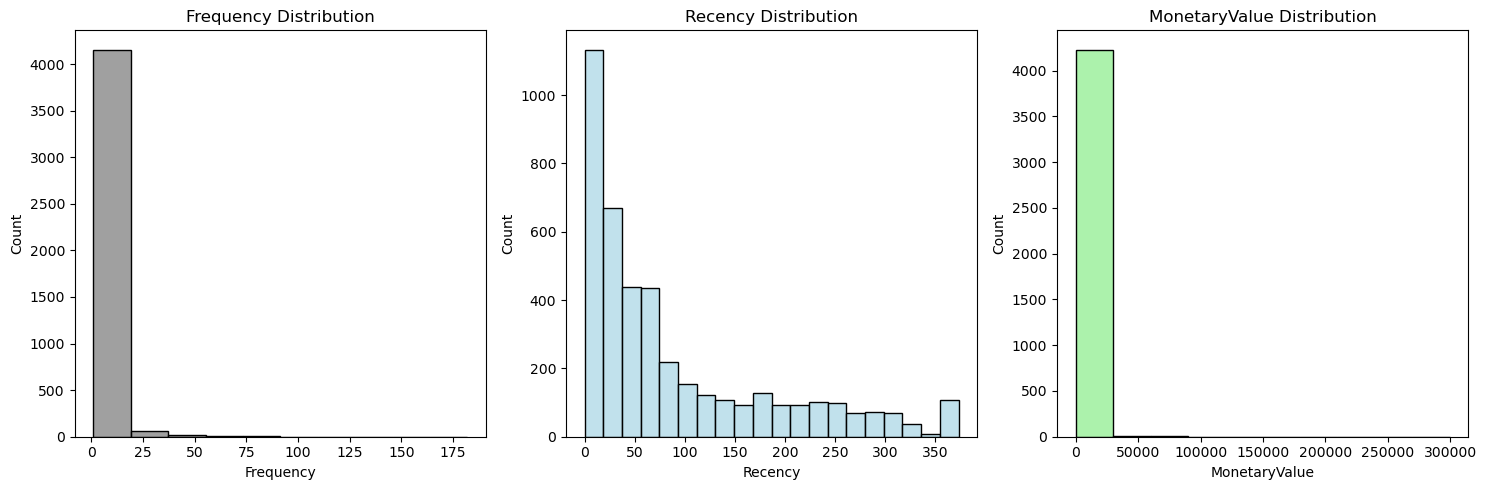

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(aggregated_df['Frequency'],bins = 10,color= "grey",edgecolor = "black")
plt.title("Frequency Distribution")

plt.subplot(1,3,2)
sns.histplot(aggregated_df['Recency'],bins = 20,color= "lightblue",edgecolor = "black")
plt.title("Recency Distribution")

plt.subplot(1,3,3)
sns.histplot(aggregated_df['MonetaryValue'],bins = 10,color= "lightgreen",edgecolor = "black")
plt.title("MonetaryValue Distribution")

plt.tight_layout()
plt.show()

Seems like our distribution are okay and on frequency most of the data falls in one bin same as monetary value , the recency seems to follow a poisson distribution like trend.To be more rigorous with our outlier detection lets use boxplots.

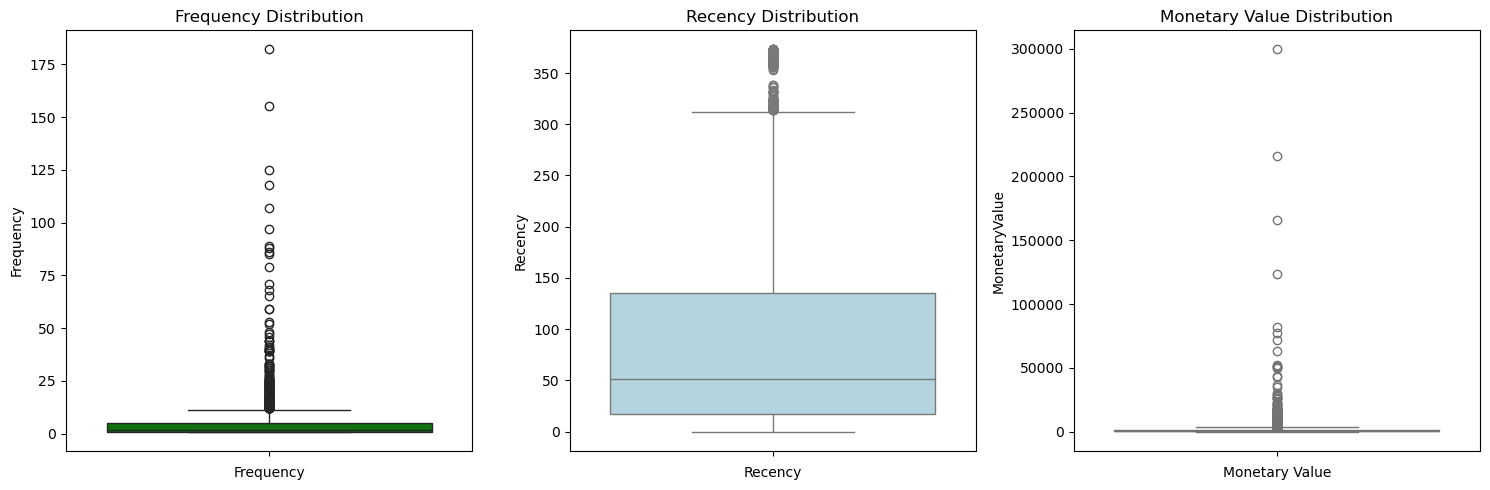

In [53]:
plt.figure(figsize=(15, 5))

# Plot 1: Boxplot for Frequency
plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df, y='Frequency', color="green")
plt.title("Frequency Distribution")
plt.xlabel("Frequency")

# Plot 2: Boxplot for Recency
plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df, y='Recency', color="lightblue")
plt.title("Recency Distribution")
plt.xlabel("Recency")

# Plot 3: Boxplot for Monetary Value
plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df, y='MonetaryValue', color="lightgreen")
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary Value")


# Adjust layout
plt.tight_layout()
plt.show()

 Its not easy to interpret the frequency and the monetary boxplots due to the excessive outliers present. Thhe recency shows to be positvely skewed , evidently 50% of the transactions happend in 50 days and less and 75% happened in aound 140 days

## Decision for outliers

Its notably that the are lot of outliers and dropping them for the sake of the model would be a very poor decisision because these outliers are our most valuable customers who buys a lot from us and spend alot ,So we will separate the outliers and model them alone.

In [57]:
#Separating the outliers using the IQR method
M_Q1 = aggregated_df['MonetaryValue'].quantile(0.25)
M_Q3 = aggregated_df['MonetaryValue'].quantile(0.75)
M_IQR = M_Q3-M_Q1 

#Calculating max
M_max = M_Q3 + (1.5*M_IQR)
M_min = M_Q1 - (1.5*M_IQR)

#for frequency
#Separating the outliers using the IQR method
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3-F_Q1 

#Calculating max
F_max = F_Q3 + (1.5*F_IQR)
F_min = F_Q1 - (1.5*F_IQR)

In [58]:
frequency_outliers_df = aggregated_df[(aggregated_df['Frequency']>F_max) | (aggregated_df['Frequency']<F_min)].copy()
monetary_outliers_df = aggregated_df[(aggregated_df['MonetaryValue']>M_max) | (aggregated_df['Frequency']<M_min)].copy()

In [59]:
#Checking the statistics of the outliers
frequency_outliers_df.describe()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency
count,269.00,269.00,269,269.00,269.00
mean,15392.80,23.70,2010-11-23 16:23:39.033456896,12298.98,15.87
min,12437.00,12.00,2010-05-12 16:51:00,898.14,0.00
25%,13831.00,13.00,2010-11-21 10:38:00,3638.01,2.00
50%,15527.00,17.00,2010-12-02 12:09:00,5572.67,7.00
75%,16883.00,24.00,2010-12-07 12:43:00,10269.46,18.00
max,18260.00,182.00,2010-12-09 19:32:00,299485.80,211.00
std,1748.38,21.58,NaN,27198.75,26.79


In [60]:
#Checking for monetary
monetary_outliers_df.describe()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency
count,412.00,412.00,412,412.00,412.00
mean,15083.30,17.03,2010-11-10 21:01:28.106796032,10433.19,28.67
min,12357.00,1.00,2009-12-10 18:03:00,3308.90,0.00
25%,13561.75,8.00,2010-11-08 13:45:45,3957.30,3.00
50%,14956.50,12.00,2010-11-26 15:03:30,5389.85,13.00
75%,16653.00,18.00,2010-12-06 12:47:30,8847.18,31.00
max,18260.00,182.00,2010-12-09 19:32:00,299485.80,364.00
std,1733.82,19.38,NaN,22291.55,49.15


# Continuing with non-outliers

In [62]:
non_outliers = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]
non_outliers.describe()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency
count,3785.00,3785.00,3785,3785.00,3785.00
mean,15372.18,2.86,2010-09-03 14:28:03.788639232,773.15,96.95
min,12346.00,1.00,2009-12-01 12:55:00,2.95,0.00
25%,13909.00,1.00,2010-07-08 16:56:00,236.40,22.00
50%,15379.00,2.00,2010-10-12 17:17:00,508.57,58.00
75%,16847.00,4.00,2010-11-17 13:42:00,1115.97,154.00
max,18287.00,11.00,2010-12-09 20:01:00,3298.60,373.00
std,1691.82,2.23,NaN,714.34,98.12


we still have some variability in the datasets but not that bad than before looking at the frequency we have a mean of 2.86 and a standard deviation of 2.23

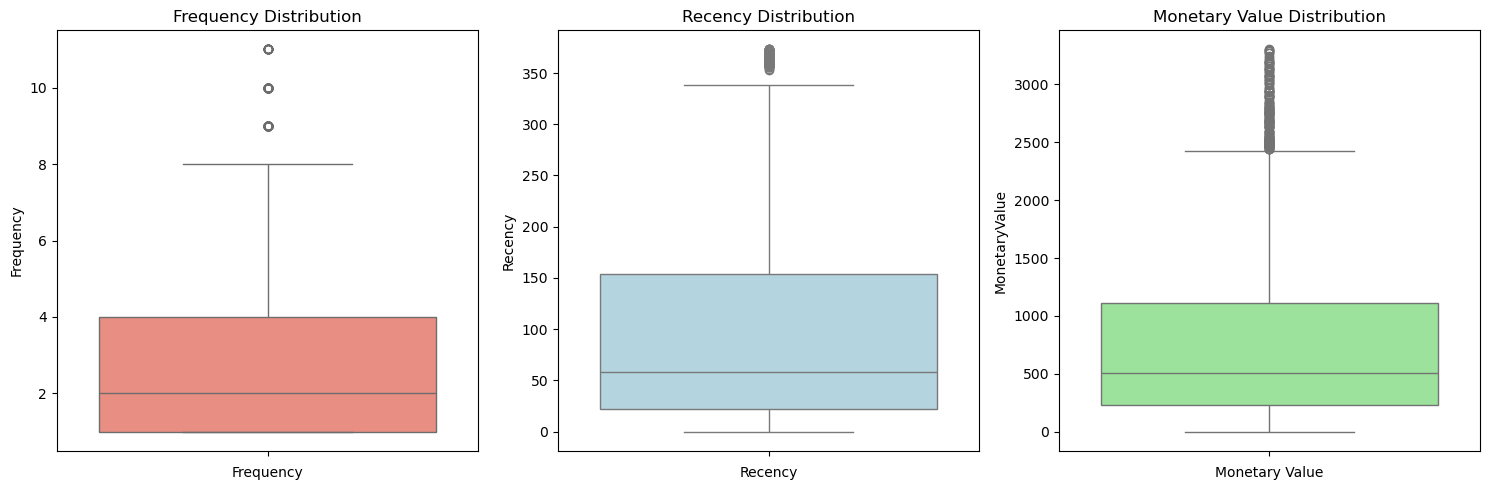

In [64]:
plt.figure(figsize=(15, 5))

# Plot 1: Boxplot for Frequency
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers, y='Frequency', color="salmon")
plt.title("Frequency Distribution")
plt.xlabel("Frequency")

# Plot 2: Boxplot for Recency
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers, y='Recency', color="lightblue")
plt.title("Recency Distribution")
plt.xlabel("Recency")

# Plot 3: Boxplot for Monetary Value
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers, y='MonetaryValue', color="lightgreen")
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary Value")


# Adjust layout
plt.tight_layout()
plt.show()

Our data is much better now is more tolarable than it was before.

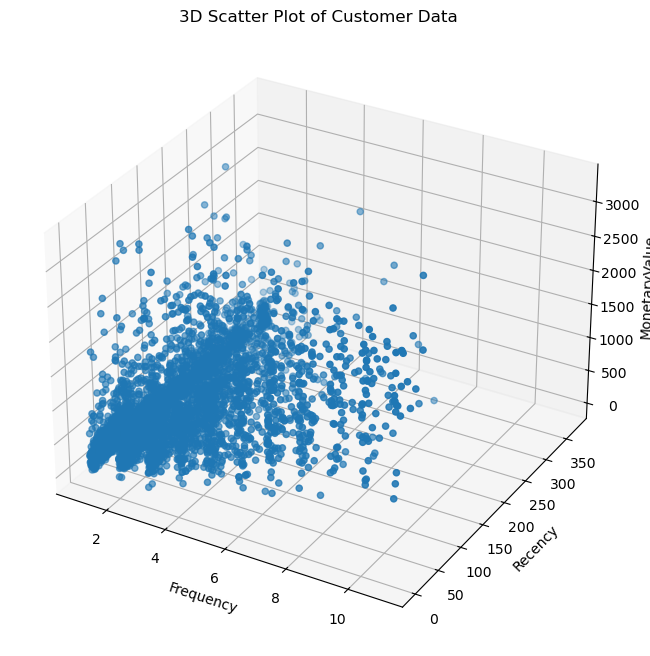

<Figure size 640x480 with 0 Axes>

In [66]:
#Creating a 3D plot of the non_outliers
fig =plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection = "3d")
scatter = ax.scatter(non_outliers['Frequency'],non_outliers['Recency'],non_outliers['MonetaryValue'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('MonetaryValue')
ax.set_title("3D Scatter Plot of Customer Data")
plt.show()
plt.tight_layout()

Its apparent that the data scales are to different which might cause an algorithm to give more importance to monetary value than the others which is not what we want all the features are equally important.So this data need to be scaled.

In [68]:
#creating a scaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers[['Frequency','Recency','MonetaryValue']])

scaled_data

array([[-0.3837042 ,  0.68341659, -0.88083728],
       [-0.3837042 , -0.96777989,  0.27122348],
       [-0.83167471, -0.24410736, -0.77283465],
       ...,
       [-0.83167471,  2.01864337, -0.57690661],
       [-0.3837042 ,  0.14321033,  0.24522389],
       [ 0.51223682, -0.81489133,  1.0789611 ]])

In [69]:
#converting the numpy array to a dataframe
scaled_data_df = pd.DataFrame(scaled_data,index = non_outliers.index,columns =['Frequency','Recency','MonetaryValue'])
scaled_data_df

,Frequency,Recency,MonetaryValue
0,-0.38,0.68,-0.88
1,-0.38,-0.97,0.27
2,-0.83,-0.24,-0.77
3,-0.38,-0.56,1.64
4,-0.83,-0.89,-0.66
...,...,...,...
4243,1.41,-0.81,-0.29
4244,-0.83,-0.32,-0.53
4245,-0.83,2.02,-0.58
4246,-0.38,0.14,0.25


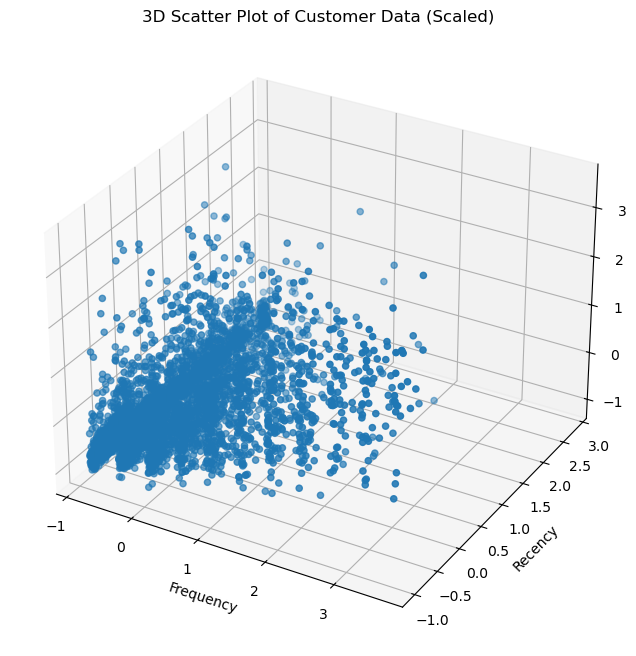

<Figure size 640x480 with 0 Axes>

In [70]:
#Creating a 3D plot of the non_outliers
fig =plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection = "3d")
scatter = ax.scatter(scaled_data_df['Frequency'],scaled_data_df['Recency'],scaled_data_df['MonetaryValue'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('MonetaryValue')
ax.set_title("3D Scatter Plot of Customer Data (Scaled)")
plt.show()
plt.tight_layout()

## KMeans Clustering

In Kmeans clustering, the goal is to identify stable centroids for the clusters. Since the algorithm requires the number of clusters (k) to be specified beforehand, determining the optimal value of k is crucial for accurate clustering. To achieve this, we will explore techniques such as the elbow method and silhouette score to estimate the best value for k.

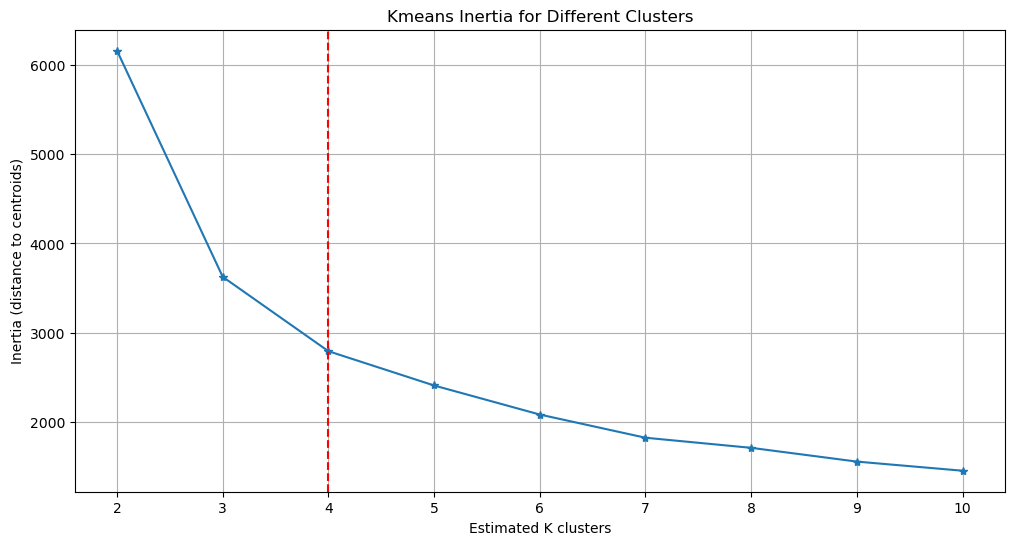

In [73]:
 #plotting the elbow plot
max_k = 10
inertia = []
k_values = range(2,max_k +1)

#looping through each k for the k means inertia
for k in k_values:
    kmeans = KMeans(n_clusters= k,max_iter= 1000,random_state= 42)
    kmeans.fit_predict(scaled_data_df)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.plot(k_values,inertia, marker= "*")
plt.xlabel("Estimated K clusters")
plt.ylabel("Inertia (distance to centroids)" )
plt.title("Kmeans Inertia for Different Clusters")
plt.axvline(x=4, color="red", linestyle="--", label="Optimal k (4)")
plt.grid(True)

plt.show()

The "elbow point" is where the rate of decrease in inertia slows significantly, indicating diminishing returns in clustering performance.

In this instance, the elbow point occurs at 4 clusters, suggesting that 4 is the optimal number of clusters for this dataset.

### The Silhoutte Score

To help us make the decision of choosing 4 or 5 clusters we use another metric called the Silhoutte distance.The Silhouette Score is a metric used to evaluate the quality of clustering. It measures how similar data points within the same cluster are compared to data points in other clusters. The score ranges from −1 to 1, with higher values indicating better-defined clusters.

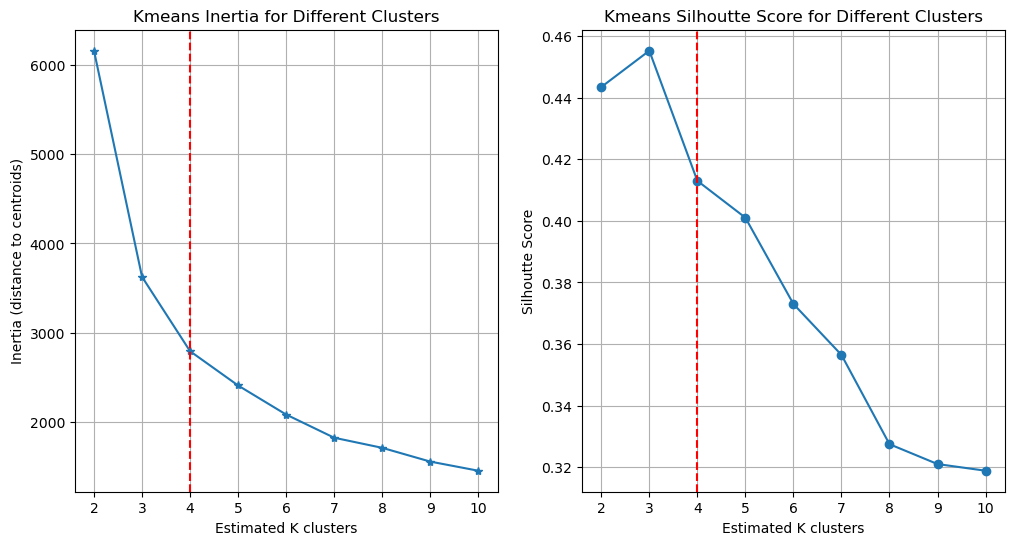

In [77]:
 #plotting the elbow plot
max_k = 10
inertia = []
silhoutte_scores =[]
k_values = range(2,max_k +1)

#looping through each k for the k means inertia
for k in k_values:
    kmeans = KMeans(n_clusters= k,max_iter= 1000,random_state= 42)
    cluster_labels =kmeans.fit_predict(scaled_data_df)
    sil_scores = silhouette_score(scaled_data_df,cluster_labels)
    silhoutte_scores.append(sil_scores)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(k_values,inertia, marker= "*")
plt.xlabel("Estimated K clusters")
plt.ylabel("Inertia (distance to centroids)" )
plt.title("Kmeans Inertia for Different Clusters")
plt.axvline(x=4, color="red", linestyle="--", label="Optimal k (4)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(k_values,silhoutte_scores, marker= "o")
plt.xlabel("Estimated K clusters")
plt.ylabel("Silhoutte Score" )
plt.title("Kmeans Silhoutte Score for Different Clusters")
plt.axvline(x=4, color="red", linestyle="--", label="Optimal k (4)")
plt.grid(True)
plt.tight_layout
plt.show()

It is evident that 4 clusters have a significantly better silhouette score than 5 clusters, indicating less potential overlap between clusters. This suggests that 4 is the optimal number of clusters k for our algorithm.

In [79]:
#Perfoming the clustering
kmeans =KMeans(n_clusters= 4, random_state= 42,max_iter= 1000)
cluster_labels = kmeans.fit_predict(scaled_data_df)
cluster_labels

array([0, 2, 2, ..., 0, 2, 1])

In [80]:
#Assigning the cluster labels to the datafram
non_outliers['Cluster'] = cluster_labels
non_outliers.head()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency,Cluster
0,12346.00,2,2010-06-28 13:53:00,144.02,164,0
1,12347.00,2,2010-12-07 14:57:00,966.87,2,2
2,12348.00,1,2010-09-27 14:59:00,221.16,73,2
3,12349.00,2,2010-10-28 08:23:00,1946.64,42,1
4,12351.00,1,2010-11-29 15:23:00,300.93,10,2


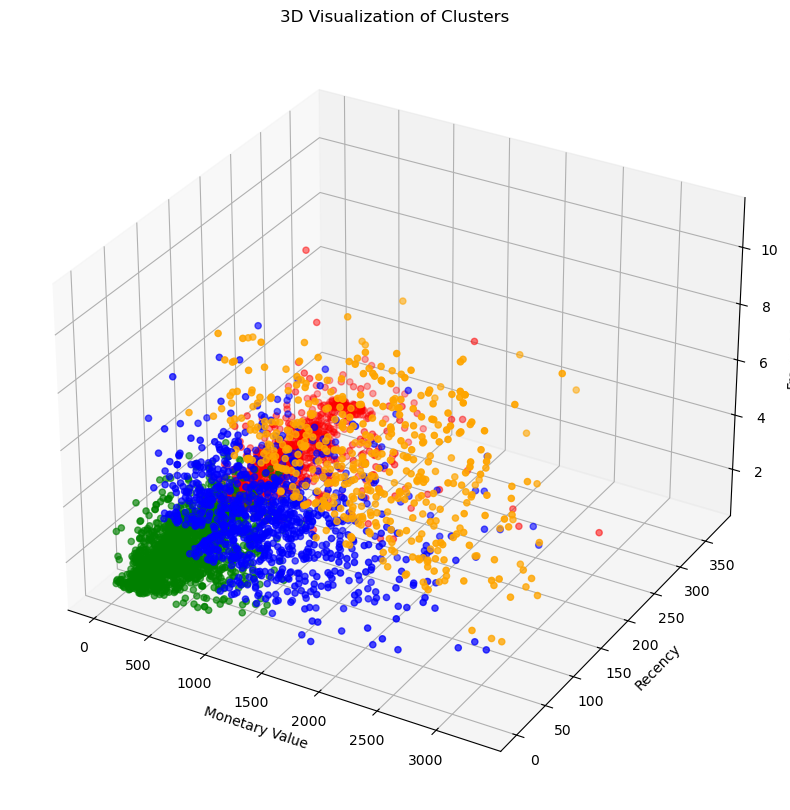

In [81]:
# Visualizing the clusters
cluster_color_dict = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange"
}
colours = non_outliers['Cluster'].map(cluster_color_dict)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plotting a scatter plot
scatter = ax.scatter(non_outliers['MonetaryValue'],
                     non_outliers['Recency'],
                     non_outliers['Frequency'],
                     c=colours,
                     marker="o")

# Setting axis labels
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

# Adding a title
ax.set_title('3D Visualization of Clusters')

plt.show()


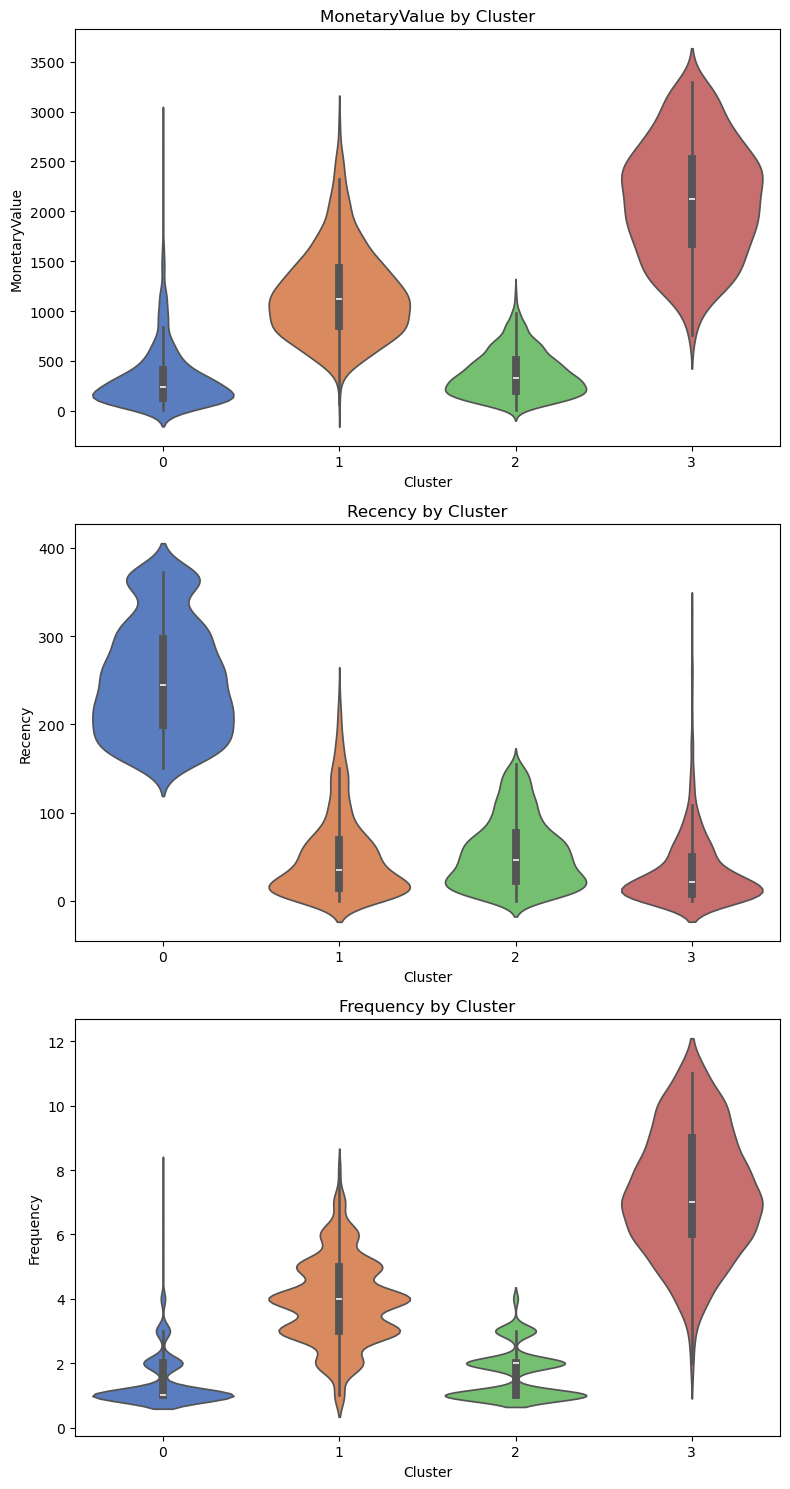

In [82]:
features = ['MonetaryValue', 'Recency', 'Frequency'] 
num_features = len(features)

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Create a violin plot for each feature in separate rows
for i, feature in enumerate(features):
    sns.violinplot(data=non_outliers, x='Cluster', y=feature, ax=axes[i], palette="muted")
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()

plt.show()

# Cluster Profiling

**Cluster 0 (Blue) (Nurture):**  
- **Analysis:** This cluster consists of the least active customers who exhibit low monetary value and infrequent purchases. These customers may be new or require nurturing to increase their engagement and spending.  
- **Action:** Prioritize building strong relationships with these customers by delivering exceptional customer service. Consider offering tailored incentives to encourage more frequent purchases and higher spending.


**Cluster 1 (Orange) (Retain):**  
- **Analysis:** This cluster represents high-value customers who contribute significantly in terms of monetary value and demonstrate recent and frequent purchase behavior.  
- **Action:** Strengthen relationships with these customers by offering personalized incentives, exclusive discounts, and targeted reminders. These strategies can encourage loyalty and further increase their spendin


**Cluster 2 (Gree(Re-engage)n):**  
- **Analysis:** This cluster includes customers who spend relatively less but have made very recent purchases, albeit with low frequency. Building trust with these customers could encourage higher spending and increased purchase frequency, leveraging their strong recency.  
- **Action:** Focus on delivering excellent customer support and actively engaging with these customers. Offer bulk purchase discounts to incentivize larger spending and send personalized reminders to keep your brand top of min

**Cluster 3 ((Reward)Red):**  
- **Analysis:** This cluster represents top-tier customers who demonstrate high spending, recent activity, and fairly frequent purchases. They are the most valuable segment of your customer base.  
- **Action:** Prioritize maintaining their loyalty by offering exclusive discounts, rewards, and personalized incentives. Implement loyalty programs to recognize and celebrate their commitment, ensuring they remain engaged and satisfied.
    

In [85]:
#Mapping the Action to each cluster to make things for analyst
action ={0:"Nurture",
         1:"Retain",
         2:"Re-engage",
         3:"Reward"}
non_outliers['Action'] =non_outliers['Cluster'].map(action)

In [86]:
non_outliers.head()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency,Cluster,Action
0,12346.00,2,2010-06-28 13:53:00,144.02,164,0,Nurture
1,12347.00,2,2010-12-07 14:57:00,966.87,2,2,Re-engage
2,12348.00,1,2010-09-27 14:59:00,221.16,73,2,Re-engage
3,12349.00,2,2010-10-28 08:23:00,1946.64,42,1,Retain
4,12351.00,1,2010-11-29 15:23:00,300.93,10,2,Re-engage


## Outliers Analysis

Before analyzing the outliers, it's important to note that some overlap exists among them, meaning there are customers who are both high spenders and frequent buyers simultaneously. Our goal is to model these intersecting customers, as well as those who are only frequent buyers and those who are only high spenders.

In [89]:
#Getting frequent high buyers
outliers_intersection = frequency_outliers_df.index.intersection(monetary_outliers_df.index)
outliers_intersection

Index([  64,   83,   84,   91,  124,  143,  162,  177,  199,  200,
       ...
       4072, 4090, 4108, 4121, 4165, 4199, 4200, 4201, 4205, 4226],
      dtype='int64', length=218)

In [90]:
frequent_outliers_only = frequency_outliers_df.drop(outliers_intersection)
monetary_outliers_only = monetary_outliers_df.drop(outliers_intersection)
monetary_and_frequency = frequency_outliers_df.loc[outliers_intersection]

We now create a cluster column for each group, marking the clusters as negative values to indicate that they are not the result of KMeans clustering but are manually grouped instead.

In [92]:
#Assigning different clusters in each group
frequent_outliers_only['Cluster'] = -1
monetary_outliers_only['Cluster']=-2
monetary_and_frequency['Cluster']=-3

In [93]:
#Creating one dataframe for the modelled outliers
oulier_clusters = pd.concat([frequent_outliers_only,
monetary_outliers_only,
monetary_and_frequency])

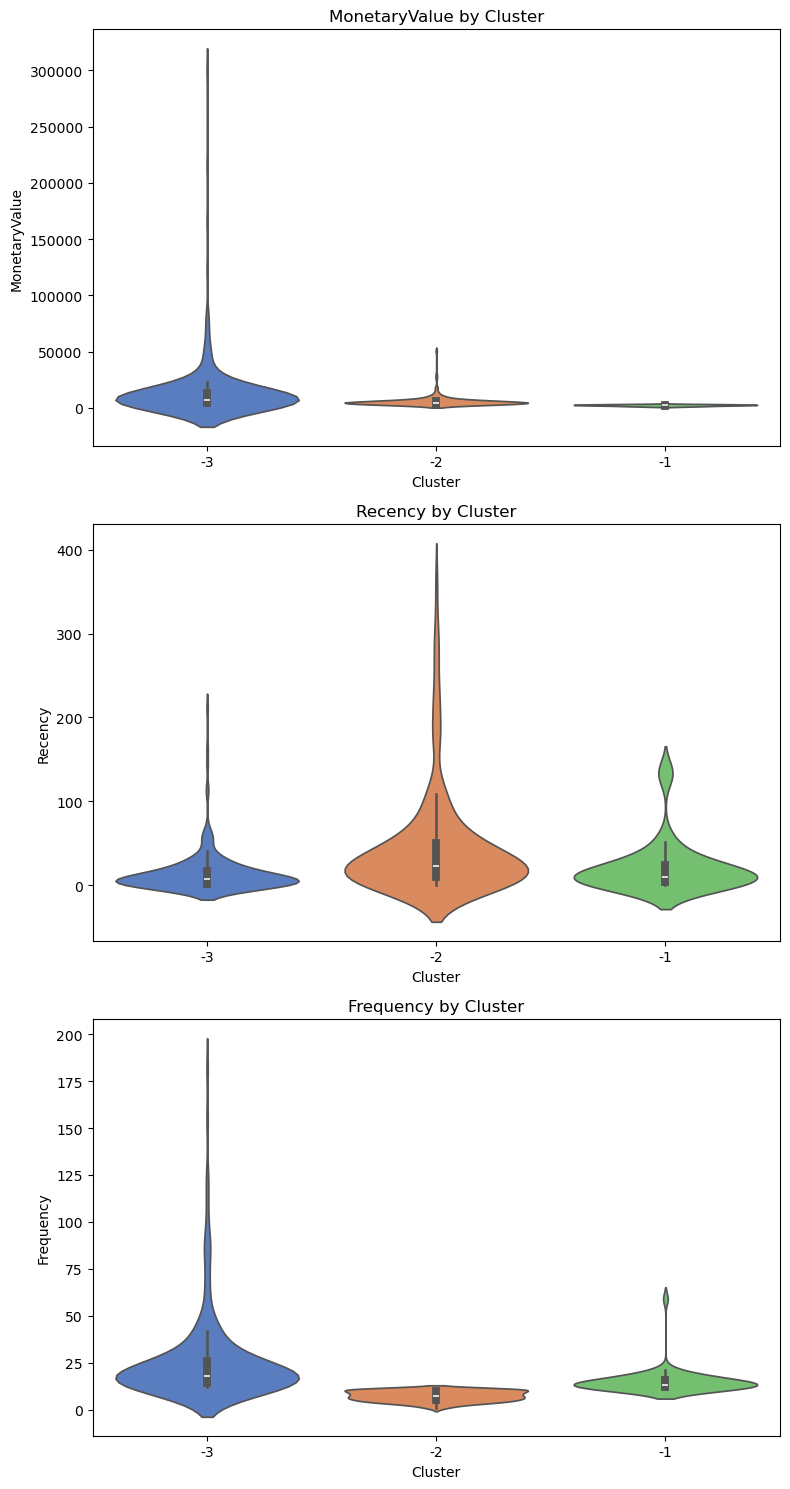

In [94]:
features = ['MonetaryValue', 'Recency', 'Frequency']  # List of features to plot
num_features = len(features)

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Create a violin plot for each feature in separate rows
for i, feature in enumerate(features):
    sns.violinplot(data=oulier_clusters, x='Cluster', y=feature, ax=axes[i], palette="muted")
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()

plt.show()


**Cluster -3 (Reward):**
- **Analysis**: These are extremely frequent buyers who are also significant spenders in our business, making them our top-tier customers.  
- **Action**: Implement VIP programs to ensure they feel recognized and appreciated, fostering loyalty. Provide specialized offers and engagement opportunities to maintain their strong connection with us and ofer luxury services that caters their high spending capacity.

**Cluster -2 (Nurture):**  
- **Analysis**: These are frequent buyers who purchase often but with lower spending and minimal engagement with the business. They could benefit from upselling opportunities.  
- **Action**: Offer them discounts on bundle deals to encourage higher spending per visit and implement strategies to actively engage with the

**Cluster -1(Re-Engage):**  
- **Analysis**: These customers are very low spenders but exhibit high purchase frequency, similar to Cluster -2. They buy often with minimal spending.  
- **Action**: Focus on maintaining their loyalty by offering exclusive bundle deals and actively engaging with them. With the right nurturing, they have significant potential to become high spenders.m.

In [96]:
#mapping on outliers
action ={-2:"Nurture",
         -3:"Retain",
         -1:"Re-engage"}
oulier_clusters['Action'] =oulier_clusters['Cluster'].map(action)

In [97]:
#Creating one dataframe for the ouliers and non outliers

clustered_all_df = pd.concat([oulier_clusters,non_outliers])
clustered_all_df.tail()

,Customer ID,Frequency,LastInvoiceDate,MonetaryValue,Recency,Cluster,Action
4243,18283.00,6,2010-11-22 15:30:00,563.19,17,1,Retain
4244,18284.00,1,2010-10-04 11:33:00,391.28,66,2,Re-engage
4245,18285.00,1,2010-02-17 10:24:00,361.10,295,0,Nurture
4246,18286.00,2,2010-08-20 11:57:00,948.30,111,2,Re-engage
4247,18287.00,4,2010-11-22 11:51:00,1543.79,17,1,Retain


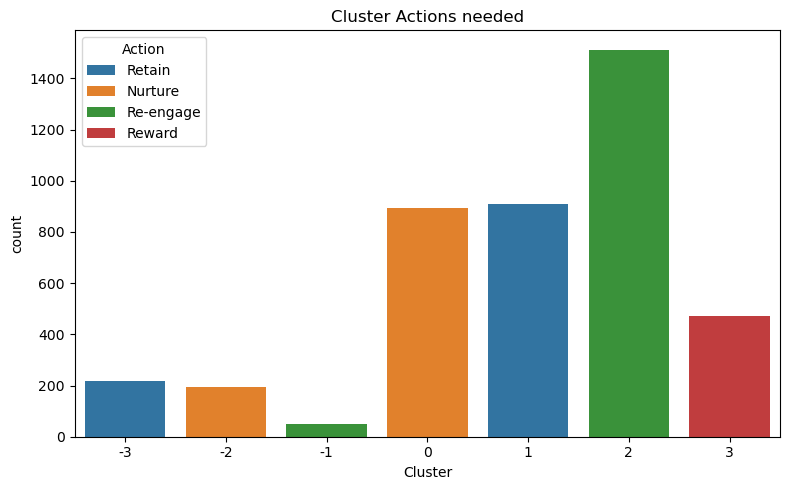

In [98]:
plt.figure(figsize= (8,5))
sns.countplot(data=clustered_all_df, x='Cluster',hue = "Action")
plt.title("Cluster Actions needed")
plt.tight_layout()
plt.show()

In [166]:
 !jupyter nbconvert --to pdf RFM_Kmeans.ipynb


[NbConvertApp] Converting notebook RFM_Kmeans.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'RFM_Kmeans.ipynb'
Traceback (most recent call last):
  File "C:\Users\diban\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 479, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diban\anaconda3\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 389, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diban\anaconda3\Lib\site-packages\nbconvert\exporters\exporter.py", line 203, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diban\anaconda3\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 395, in from_file
    return 

In [168]:
pandoc --version


NameError: name 'pandoc' is not defined